In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models, Input
from transformers import AutoConfig, TFAutoModel, ViTFeatureExtractor, ViTConfig
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Dense, Flatten, Reshape, LayerNormalization, Dropout, 
    MultiHeadAttention, Add, GlobalAveragePooling1D
)
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import (
    confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
)
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Paths to folders
base_dir = "HAM10000"
benign_dir = os.path.join(base_dir, "Benign")
malignant_dir = os.path.join(base_dir, "Malignant")

In [3]:
# Collect image file paths and labels
def collect_image_paths(directory, label):
    image_paths = [os.path.join(directory, fname) for fname in os.listdir(directory) if fname.endswith(('.jpg', '.jpeg', '.png'))]
    labels = [label] * len(image_paths)
    return pd.DataFrame({"filepath": image_paths, "label": labels})

In [4]:
# Create a DataFrame for Benign and Malignant images
benign_df = collect_image_paths(benign_dir, label='benign')  # Benign (Non-Cancerous)
malignant_df = collect_image_paths(malignant_dir, label='malignant')  # Malignant (Cancerous)

In [5]:
# Combine into one DataFrame
data_df = pd.concat([benign_df, malignant_df]).reset_index(drop=True)

In [6]:
data_df

,filepath,label
0,HAM10000\Benign\ISIC_0024306.jpg,benign
1,HAM10000\Benign\ISIC_0024307.jpg,benign
2,HAM10000\Benign\ISIC_0024308.jpg,benign
3,HAM10000\Benign\ISIC_0024309.jpg,benign
4,HAM10000\Benign\ISIC_0024311.jpg,benign
...,...,...
9991,HAM10000\Malignant\ISIC_0034299.jpg,malignant
9992,HAM10000\Malignant\ISIC_0034306.jpg,malignant
9993,HAM10000\Malignant\ISIC_0034313.jpg,malignant
9994,HAM10000\Malignant\ISIC_0034316.jpg,malignant


In [7]:
# Split into train, validation, and test sets (70/20/10 split)
train_df, temp_df = train_test_split(data_df, test_size=0.3, stratify=data_df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=1/3, stratify=temp_df["label"], random_state=42)

In [8]:
# Verify the splits
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 6997
Validation size: 1999
Test size: 1000


In [9]:
# Augmented Data Generator for Training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,          # Random rotation up to 20 degrees
    zoom_range=0.15,            # Random zoom between 85% and 115%
    width_shift_range=0.1,      # Horizontal shift up to 10%
    height_shift_range=0.1,     # Vertical shift up to 10%
    shear_range=0.15,           # Shear intensity
    horizontal_flip=True,       # Random horizontal flip
    brightness_range=(0.8, 1.2) # Adjust brightness between 80%-120%
)

In [10]:
# No augmentation for validation and test sets (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [11]:
# Train generator
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),  # Resize to your model's input size
    batch_size=32,
    class_mode="binary",     # Binary classification
    shuffle=True
)

# Validation generator
val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)

# Test generator
test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)

Found 6997 validated image filenames belonging to 2 classes.
Found 1999 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


In [12]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)

In [13]:
# Convert to a dictionary for TensorFlow
class_weights_dict = dict(enumerate(class_weights))

print(f"Class Weights: {class_weights_dict}")

Class Weights: {0: 0.6215135903357613, 1: 2.5573830409356724}


In [14]:
# Create a Weighted Loss Function
def weighted_binary_crossentropy(class_weights):
    def loss(y_true, y_pred):
        weights = y_true * class_weights[1] + (1 - y_true) * class_weights[0]
        bce = K.binary_crossentropy(y_true, y_pred)
        return K.mean(weights * bce)
    return loss

In [15]:
class_weights_dict = {0: 0.6215135903357613, 1: 2.5573830409356724}
weighted_loss = weighted_binary_crossentropy(class_weights_dict)

## Model 1 - Basic CNN

In [14]:
# Define the CNN model
def build_cnn_model(input_shape=(224, 224, 3)):
    model = models.Sequential()

    # First Convolutional Block
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Block
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Third Convolutional Block
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Fourth Convolutional Block
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Flatten and Fully Connected Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))  # Regularization
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Regularization

    # Output Layer
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification output
    
    return model

In [15]:
# Build the model
cnn_model = build_cnn_model()

# Summary of the model
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      12,845,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             1

 Total params: 13,269,697 (50.62 MB)

 Trainable params: 13,268,225 (50.61 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [18]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=weighted_loss,
    metrics=['accuracy']
)

In [19]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = val_generator.samples // val_generator.batch_size

In [19]:
# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    filepath='cnn_model_binary.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [20]:
cnn_history = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[checkpoint]
)

Epoch 1/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - accuracy: 0.5905 - loss: 0.7420 - val_accuracy: 0.2836 - val_loss: 0.6822
Epoch 2/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - accuracy: 0.5991 - loss: 0.6157 - val_accuracy: 0.5838 - val_loss: 0.5328
Epoch 3/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - accuracy: 0.6081 - loss: 0.5622 - val_accuracy: 0.4127 - val_loss: 0.6327
Epoch 4/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - accuracy: 0.6422 - loss: 0.5294 - val_accuracy: 0.4582 - val_loss: 0.6235
Epoch 5/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - accuracy: 0.6495 - loss: 0.5034 - val_accuracy: 0.5078 - val_loss: 0.5802
Epoch 6/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - accuracy: 0.6871 - loss: 0.4952 - val_accuracy: 0.5548 - val_loss: 0.5858
Epoch 7/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.6625 - loss: 0.4879 - val_accuracy: 0.7844 - val_loss: 0.5903
Epoch 8/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/step - accuracy: 0.6969 - loss: 0.4742 - val_accu

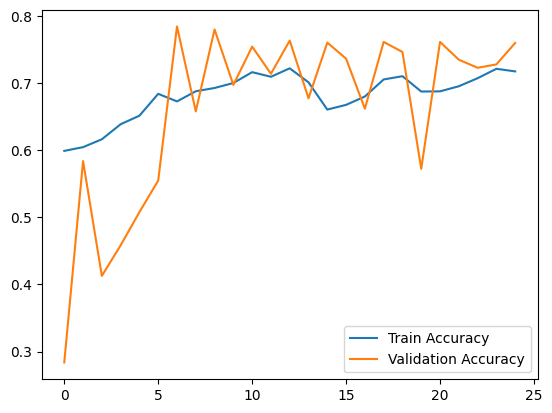

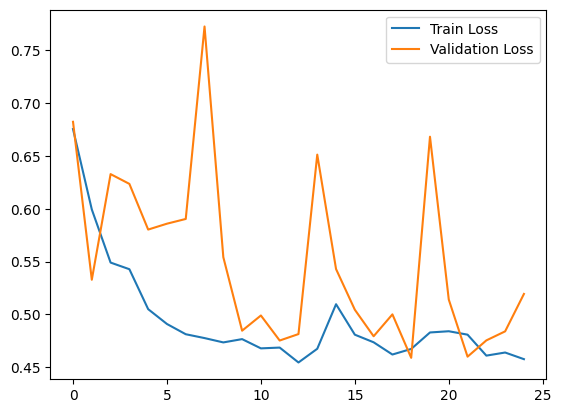

In [21]:
# Plot accuracy
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [24]:
cnn_model = load_model('cnn_model_binary.keras', custom_objects={'custom_loss': weighted_loss})

In [25]:
# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 282ms/step - accuracy: 0.7871 - loss: 0.6333
Test Loss: 0.5933
Test Accuracy: 0.7980


In [26]:
# Get predictions and true labels
predictions = cnn_model.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions
true_labels = test_generator.classes  # Actual labels from the test generator

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 282ms/step


In [29]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
TN, FP, FN, TP = conf_matrix.ravel()

In [30]:
# Compute Metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, pos_label=1)
recall = recall_score(true_labels, predicted_labels, pos_label=1)
f1 = f1_score(true_labels, predicted_labels, pos_label=1)
specificity = TN / (TN + FP)  # Specificity for the negative class

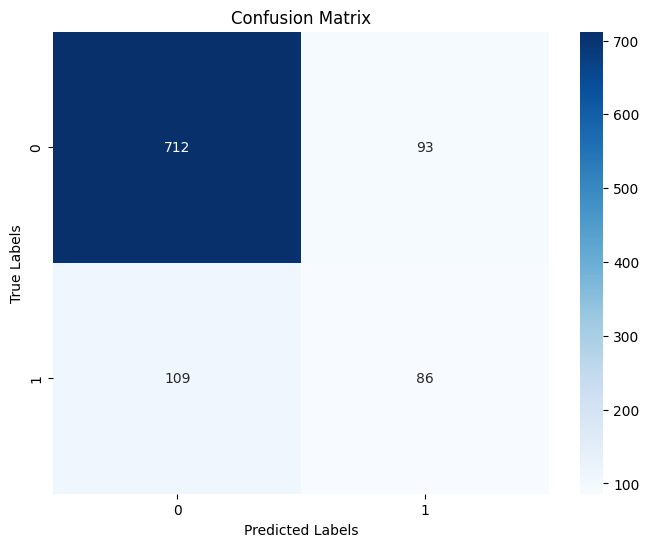

In [33]:
# Display the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [34]:
# Print the Metrics
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score: {f1:.4f}")

Confusion Matrix:
[[712  93]
 [109  86]]
Accuracy: 0.7980
Precision: 0.4804
Recall (Sensitivity): 0.4410
Specificity: 0.8845
F1-Score: 0.4599


## Model 2 - Restnet50 with transformer

In [35]:
# Define input
input_shape = (224, 224, 3)
inputs = Input(shape=input_shape)

In [36]:
# CNN Backbone
cnn_base = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
cnn_output = cnn_base.output  # Shape: (None, 7, 7, 2048)

In [37]:
# Reshape CNN output to sequence
sequence_length = cnn_output.shape[1] * cnn_output.shape[2]  # 7*7=49
embedding_dim = cnn_output.shape[3]  # 2048

In [38]:
x = Reshape((sequence_length, embedding_dim))(cnn_output)  # Shape: (None, 49, 2048)

In [39]:
# Reduce Embedding Dimension
embedding_dim_reduced = 512  # Reduce for computational efficiency
x = Dense(embedding_dim_reduced)(x)

In [40]:
# Transformer Block
def transformer_block(inputs, num_heads, key_dim, ff_dim, dropout=0.1):
    # Multi-Head Self Attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs)
    attention_output = Dropout(dropout)(attention_output)
    attention_output = Add()([inputs, attention_output])  # Residual connection
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
    
    # Feed-Forward Network
    ff_output = Dense(ff_dim, activation='relu')(attention_output)
    ff_output = Dense(embedding_dim_reduced)(ff_output)
    ff_output = Dropout(dropout)(ff_output)
    ff_output = Add()([attention_output, ff_output])  # Residual connection
    ff_output = LayerNormalization(epsilon=1e-6)(ff_output)
    
    return ff_output

In [41]:
# Parameters for transformer block
num_heads = 8
key_dim = embedding_dim_reduced // num_heads  # Ensure this is an integer
ff_dim = 512  # Feed-forward layer dimension
num_transformer_blocks = 2

In [42]:
for _ in range(num_transformer_blocks):
    x = transformer_block(x, num_heads, key_dim, ff_dim)

In [43]:
# Global Average Pooling
x = GlobalAveragePooling1D()(x)

# Classification Head
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Final Model
trans_model = Model(inputs=inputs, outputs=x)

In [44]:
trans_model.summary()

Model: "functional_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 27,924,353 (106.52 MB)

 Trainable params: 27,871,233 (106.32 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [45]:
# Compile Model
trans_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=weighted_loss,
    metrics=['accuracy']
)

In [46]:
# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    filepath='trans_model_binary.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [47]:
# Train Model
trans_history = trans_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[checkpoint]
)

Epoch 1/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 1066s 5s/step - accuracy: 0.7131 - loss: 0.5326 - val_accuracy: 0.8044 - val_loss: 1.1072
Epoch 2/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 1018s 5s/step - accuracy: 0.7787 - loss: 0.4129 - val_accuracy: 0.8044 - val_loss: 0.8191
Epoch 3/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 1032s 5s/step - accuracy: 0.8182 - loss: 0.3674 - val_accuracy: 0.8044 - val_loss: 1.4861
Epoch 4/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 1020s 5s/step - accuracy: 0.8404 - loss: 0.3306 - val_accuracy: 0.8174 - val_loss: 1.6580
Epoch 5/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 1019s 5s/step - accuracy: 0.8390 - loss: 0.3199 - val_accuracy: 0.8339 - val_loss: 0.6328
Epoch 6/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 1021s 5s/step - accuracy: 0.8539 - loss: 0.3044 - val_accuracy: 0.8654 - val_loss: 0.5641
Epoch 7/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 1019s 5s/step - accuracy: 0.8722 - loss: 0.2916 - val_accuracy: 0.8079 - val_loss: 0.3883
Epoch 8/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 1019s 5s/step - accuracy: 0.8913 - loss: 0.2526 - 

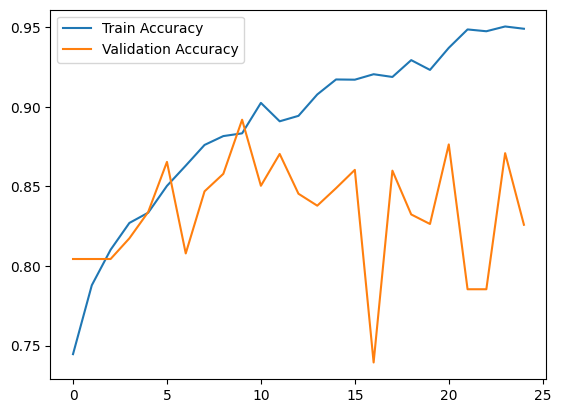

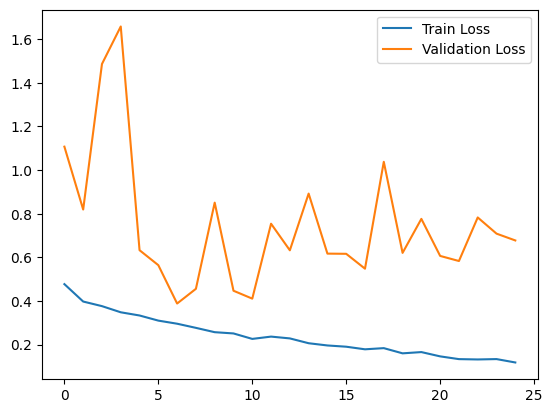

In [48]:
# Plot accuracy
plt.plot(trans_history.history['accuracy'], label='Train Accuracy')
plt.plot(trans_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(trans_history.history['loss'], label='Train Loss')
plt.plot(trans_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [49]:
trans_model = load_model('trans_model_binary.keras', custom_objects={'custom_loss': weighted_loss})

In [50]:
# Evaluate the model on the test set
test_loss, test_accuracy = trans_model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 791ms/step - accuracy: 0.8875 - loss: 0.5335
Test Loss: 0.4900
Test Accuracy: 0.8870


In [51]:
# Get predictions and true labels
predictions = trans_model.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions
true_labels = test_generator.classes  # Actual labels from the test generator

32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 832ms/step


In [52]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
TN, FP, FN, TP = conf_matrix.ravel()

In [53]:
# Compute Metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, pos_label=1)
recall = recall_score(true_labels, predicted_labels, pos_label=1)
f1 = f1_score(true_labels, predicted_labels, pos_label=1)
specificity = TN / (TN + FP)  # Specificity for the negative class

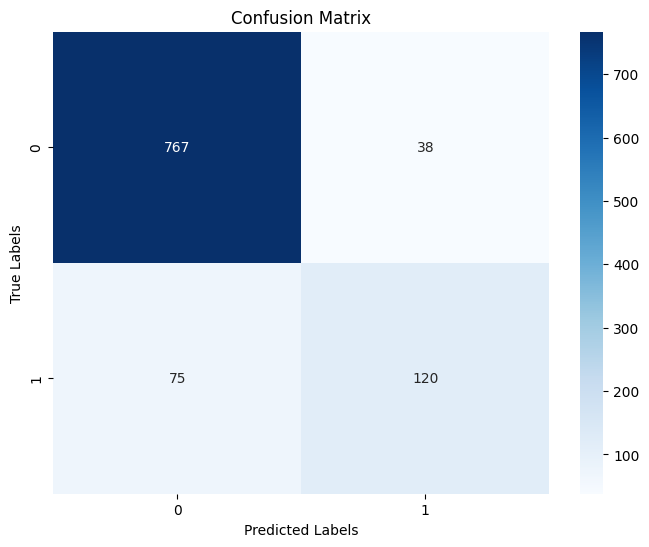

In [54]:
# Display the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [55]:
# Print the Metrics
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score: {f1:.4f}")

Confusion Matrix:
[[767  38]
 [ 75 120]]
Accuracy: 0.8870
Precision: 0.7595
Recall (Sensitivity): 0.6154
Specificity: 0.9528
F1-Score: 0.6799


## Model 3 - Inception resnet v2 with Soft Attention

In [16]:
@tf.keras.utils.register_keras_serializable(package="Custom")
class SoftAttention(layers.Layer):
    def __init__(self, **kwargs):
        super(SoftAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create the trainable scalar gamma as a weight
        self.gamma = self.add_weight(
            name='gamma',
            shape=(),
            initializer=tf.keras.initializers.Constant(0.01),
            trainable=True
        )
        # Define attention convolution layer
        self.attention_conv = layers.Conv2D(
            input_shape[-1],  # Number of channels in the input
            kernel_size=(1, 1),
            activation='sigmoid',
            kernel_initializer='he_normal'
        )

    def call(self, inputs):
        # Generate attention maps
        attention_maps = self.attention_conv(inputs)

        # Scale inputs by attention maps
        scaled_inputs = inputs * attention_maps
        scaled_inputs = self.gamma * scaled_inputs

        # Residual connection
        return inputs + scaled_inputs

In [18]:
def inception_resnet_v2_with_attention(input_shape):
    # Load Inception ResNet v2 base model
    base_model = tf.keras.applications.InceptionResNetV2(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape
    )
    # Add Soft Attention at the last convolutional block
    x = base_model.get_layer('conv_7b_ac').output
    x = SoftAttention()(x)

    # Global Average Pooling and Fully Connected Layers
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # Create the model
    model = tf.keras.models.Model(inputs=base_model.input, outputs=outputs)
    return model

In [19]:
# Define the model
input_shape = (224, 224, 3)
irv2_model = inception_resnet_v2_with_attention(input_shape)

In [21]:
irv2_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=weighted_loss,
    metrics=['accuracy']
)

In [22]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='irv2_model_binary.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [23]:
# Define a learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6
)

In [24]:
# Train the model
irv2_history = irv2_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[checkpoint, lr_scheduler]
)

Epoch 1/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 1001s 4s/step - accuracy: 0.6866 - loss: 0.5246 - val_accuracy: 0.8449 - val_loss: 0.7116 - learning_rate: 1.0000e-04
Epoch 2/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 932s 4s/step - accuracy: 0.7962 - loss: 0.3744 - val_accuracy: 0.8424 - val_loss: 0.3716 - learning_rate: 1.0000e-04
Epoch 3/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 941s 4s/step - accuracy: 0.8440 - loss: 0.3180 - val_accuracy: 0.8859 - val_loss: 0.3611 - learning_rate: 1.0000e-04
Epoch 4/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 938s 4s/step - accuracy: 0.8873 - loss: 0.2538 - val_accuracy: 0.8489 - val_loss: 0.3481 - learning_rate: 1.0000e-04
Epoch 5/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 941s 4s/step - accuracy: 0.8982 - loss: 0.2116 - val_accuracy: 0.8909 - val_loss: 0.5399 - learning_rate: 1.0000e-04
Epoch 6/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 938s 4s/step - accuracy: 0.8994 - loss: 0.2079 - val_accuracy: 0.8609 - val_loss: 0.4661 - learning_rate: 1.0000e-04
Epoch 7/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 937s 4s/step - ac

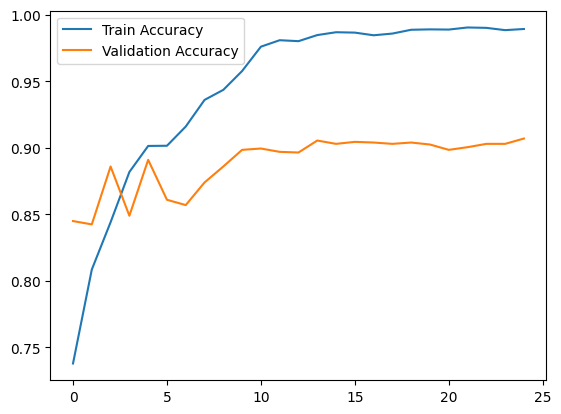

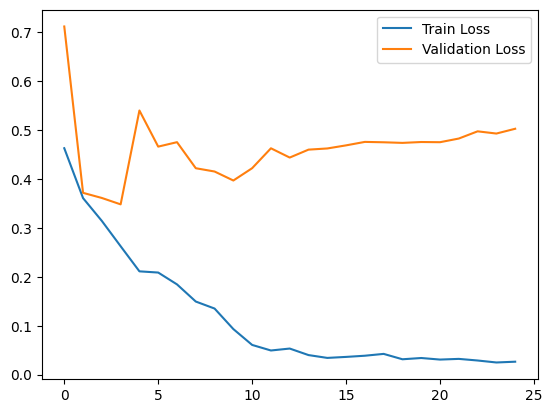

In [26]:
# Plot accuracy
plt.plot(irv2_history.history['accuracy'], label='Train Accuracy')
plt.plot(irv2_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(irv2_history.history['loss'], label='Train Loss')
plt.plot(irv2_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [27]:
irv2_model = load_model('irv2_model_binary.keras', custom_objects={'custom_loss': weighted_loss})

In [28]:
# Evaluate the model on the test set
test_loss, test_accuracy = irv2_model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 966ms/step - accuracy: 0.8999 - loss: 0.4625
Test Loss: 0.4380
Test Accuracy: 0.8960


In [29]:
# Get predictions and true labels
predictions = irv2_model.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions
true_labels = test_generator.classes  # Actual labels from the test generator

32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step 


In [30]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
TN, FP, FN, TP = conf_matrix.ravel()

In [31]:
# Compute Metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, pos_label=1)
recall = recall_score(true_labels, predicted_labels, pos_label=1)
f1 = f1_score(true_labels, predicted_labels, pos_label=1)
specificity = TN / (TN + FP)  # Specificity for the negative class

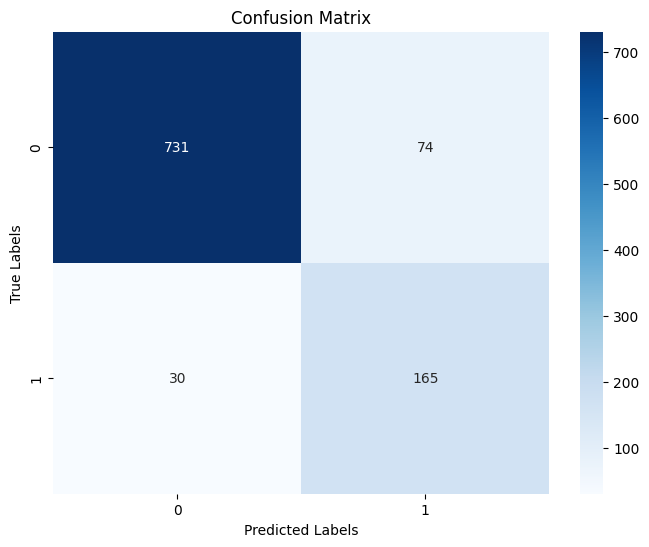

In [32]:
# Display the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [33]:
# Print the Metrics
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score: {f1:.4f}")

Confusion Matrix:
[[731  74]
 [ 30 165]]
Accuracy: 0.8960
Precision: 0.6904
Recall (Sensitivity): 0.8462
Specificity: 0.9081
F1-Score: 0.7604
